# Classification

For classification I use three models: logistic regression, a one-layer dense network, and a two-layer dense network. First the high-level features data is split in training, validation, and test data. At the end, I compare performance of the classification models for each model used for feature extraction.

## 1. Import packages, define class names, select model, and load features from file

In [32]:
import numpy as np
import os
import pandas as pd
import re
from sklearn.utils import class_weight 

In [186]:
class_names = ['adenosis',
            'ductal_carcinoma',
            'fibroadenoma',
            'lobular_carcinoma',
            'mucinous_carcinoma',
            'papillary_carcinoma',
            'phyllodes_tumor',
            'tubular_adenoma']

#### Choose one of the models

In [181]:
isVGG16=False
isInceptionV3=False
isResNet50=False
isXception=False
isDenseNet121=False
isInceptionResNetV2=False
isEfficientNet0=True

#### Set high-level feature file name

In [182]:
if isVGG16==True:             ffilename = 'features_patches_VGG16.npz'
if isInceptionV3==True:       ffilename = 'features_patches_InceptionV3.npz'
if isResNet50==True:          ffilename = 'features_patches_ResNet50.npz'
if isXception==True:          ffilename = 'features_patches_Xception.npz'
if isDenseNet121==True:       ffilename = 'features_patches_DenseNet121.npz'
if isInceptionResNetV2==True: ffilename = 'features_patches_InceptionResNetV2.npz'
if isEfficientNet0==True:     ffilename = 'features_patches_EfficientNetB0.npz'

#### Get model's name as string

In [183]:
model_str = re.sub('.*_(.*)\.npz', '\\1', ffilename)
model_str

'EfficientNetB0'

#### Load features from file

In [184]:
with np.load(os.path.join('data', 'HLfeatures', ffilename)) as features_npz:
    features_dict = dict(features_npz)

nf = features_dict['arr_0'].shape[1] - 2
features = features_dict['arr_0'][:,:nf].astype(float)
labs = features_dict['arr_0'][:,nf].astype(int)
fns = features_dict['arr_0'][:,-1]
print('Shape of features:', features.shape, '\nShape of labs:', labs.shape, '\nShape of filenames:', fns.shape)

Shape of features: (7980, 1280) 
Shape of labs: (7980,) 
Shape of filenames: (7980,)


In [185]:
print('dtype of features:', features.dtype, '\ndtype of labels:  ', labs.dtype)

dtype of features: float64 
dtype of labels:   int64


## 2. Split fetures in train (80%), validation (10%), and test (10%) data

In [187]:
from sklearn.model_selection import train_test_split

In [188]:
# Split into train/rest sets
X_tr, X_, y_tr, y_, fn_tr, fn_ = train_test_split(
    features, labs, fns,
    test_size=0.2, random_state=0)

# Split into valid/test sets
X_val, X_te, y_val, y_te, fn_val, fn_te = train_test_split(
    X_, y_, fn_, 
    test_size=0.5, random_state=0)

print('train X:', X_tr.shape, '\n      y:', y_tr.shape)
print('valid X:', X_val.shape, '\n      y:', y_val.shape)
print('test  X:', X_te.shape, '\n      y:', y_te.shape)

train X: (6384, 1280) 
      y: (6384,)
valid X: (798, 1280) 
      y: (798,)
test  X: (798, 1280) 
      y: (798,)


#### Proportion of numbers per class

In [189]:
def get_counts(y):
    labs_num = pd.DataFrame(y)[0]
    labs_num_prop = labs_num.value_counts(normalize=True).sort_index()
    labs_num_prop = np.round(labs_num_prop*100, 1)
    labs_num_count = labs_num.value_counts().sort_index()
    return(labs_num_count, labs_num_prop)

In [190]:
count_tr, prop_tr   = get_counts(y_tr)
count_val, prop_val = get_counts(y_val)
count_te, prop_te   = get_counts(y_te)

class_df = pd.DataFrame({'count train': count_tr, 'count validation': count_val, 'count test': count_te,
                         'proportion train (%)': prop_tr, 'proportion validation (%)': prop_val,'proportion test (%)': prop_te,})
class_df.index = class_names
class_df

,count train,count validation,count test,proportion train (%),proportion validation (%),proportion test (%)
adenosis,378,35,43,5.9,4.4,5.4
ductal_carcinoma,2790,334,332,43.7,41.9,41.6
fibroadenoma,808,105,99,12.7,13.2,12.4
lobular_carcinoma,505,62,57,7.9,7.8,7.1
mucinous_carcinoma,635,84,101,9.9,10.5,12.7
papillary_carcinoma,451,75,54,7.1,9.4,6.8
phyllodes_tumor,354,42,40,5.5,5.3,5.0
tubular_adenoma,463,61,72,7.3,7.6,9.0


#### Compute class weights

In [191]:
# https://stackoverflow.com/a/67678520
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr), 
    y=y_tr)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 2.111111111111111,
 1: 0.2860215053763441,
 2: 0.9876237623762376,
 3: 1.5801980198019803,
 4: 1.2566929133858267,
 5: 1.76940133037694,
 6: 2.2542372881355934,
 7: 1.7235421166306695}

## 3. Logistic regression

#### Import packages

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


#### Create the estimator

In [192]:
logreg = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='liblinear',  multi_class='auto', class_weight=train_class_weights)
)

Accuracy: 0.788


#### Fit it to train data

In [ ]:
logreg.fit(X_tr, y_tr)

#### Accuracy on test set

In [ ]:
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

#### Save result to file

In [193]:
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': 'logistic regression', 
    'test_accuracy': np.round(accuracy, 3)}, index=[0])
df.to_csv('testacc.txt', mode='a', header=False)

## 4. One-layer dense network

#### Define model

In [212]:
#import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight 

In [213]:
model = Sequential()
model.add(InputLayer(input_shape=(nf,)))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8)                 10248     
Total params: 10,248
Trainable params: 10,248
Non-trainable params: 0
_________________________________________________________________


#### Define loss function, optimizer, and metrics to track during training

In [214]:
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#### End training when accuracy stops improving (optional)

In [215]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

#### Fit model

In [216]:
#train_class_weights = {str(k):v for k,v in train_class_weights.items()}
#train_class_weights

In [217]:
history = model.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=200,
    shuffle=True, # Shuffle training samples
    callbacks=[early_stopping],
    class_weight=train_class_weights,
)

Epoch 1/200
200/200 [==============================] - 1s 2ms/step - loss: 1.7968 - acc: 0.3279 - val_loss: 1.6521 - val_acc: 0.4035
Epoch 2/200
200/200 [==============================] - 0s 1ms/step - loss: 1.4828 - acc: 0.4441 - val_loss: 1.4707 - val_acc: 0.4662
Epoch 3/200
200/200 [==============================] - 0s 2ms/step - loss: 1.3417 - acc: 0.4900 - val_loss: 1.3885 - val_acc: 0.4962
Epoch 4/200
200/200 [==============================] - 0s 1ms/step - loss: 1.2516 - acc: 0.5215 - val_loss: 1.2614 - val_acc: 0.5664
Epoch 5/200
200/200 [==============================] - 0s 1ms/step - loss: 1.1888 - acc: 0.5451 - val_loss: 1.2316 - val_acc: 0.5652
Epoch 6/200
200/200 [==============================] - 0s 2ms/step - loss: 1.1384 - acc: 0.5578 - val_loss: 1.1971 - val_acc: 0.5802
Epoch 7/200
200/200 [==============================] - 0s 1ms/step - loss: 1.0951 - acc: 0.5771 - val_loss: 1.1562 - val_acc: 0.5952
Epoch 8/200
200/200 [==============================] - 0s 1ms/step - 

#### Plot loss and accuracy values

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_acc(history, fig, axs):
    # Plot accuracy values
    ax1.plot(history.history['loss'], label='train loss')
    ax1.plot(history.history['val_loss'], label='val loss')
    ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_loss'][-3:]) # last three values
    ))
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss value')
    ax1.legend()

    # Plot accuracy values
    ax2.plot(history.history['acc'], label='train acc')
    ax2.plot(history.history['val_acc'], label='val acc')
    ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_acc'][-3:]) # last three values
    ))
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    plt.show()

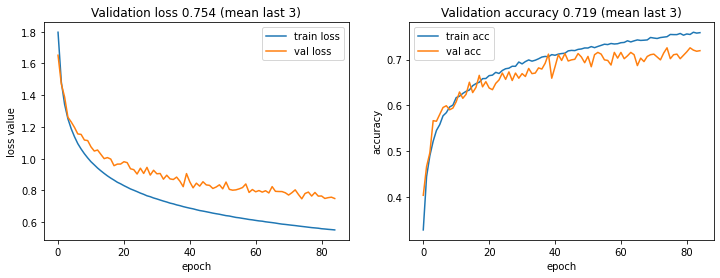

In [219]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history, fig, (ax1, ax2))

## 5. Two-layer dense network

#### Define models

In [202]:
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=nf))
model2.add(Dense(8, activation='softmax'))
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                40992     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 264       
Total params: 41,256
Trainable params: 41,256
Non-trainable params: 0
_________________________________________________________________


#### Define loss function, optimizer, and metrics to track during training

In [203]:
model2.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#### End training when accuracy stops improving (optional)

In [204]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

#### Fit model

In [205]:
history2 = model2.fit(
    x=X_tr, y=y_tr,
    validation_data=(X_val, y_val), 
    batch_size=32, 
    epochs=100,
    shuffle=True, # Shuffle training samples
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 1.6043 - acc: 0.4771 - val_loss: 1.4286 - val_acc: 0.5138
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 1.3123 - acc: 0.5459 - val_loss: 1.2317 - val_acc: 0.5627
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 1.1644 - acc: 0.5872 - val_loss: 1.1219 - val_acc: 0.6128
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0693 - acc: 0.6216 - val_loss: 1.0368 - val_acc: 0.6253
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0028 - acc: 0.6425 - val_loss: 0.9890 - val_acc: 0.6642
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9506 - acc: 0.6588 - val_loss: 0.9423 - val_acc: 0.6692
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9086 - acc: 0.6739 - val_loss: 0.9137 - val_acc: 0.6867
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - 

#### Plot loss and accuracy values

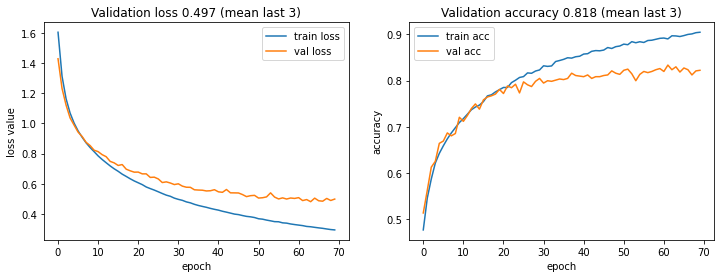

In [206]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acc(history2, fig, (ax1, ax2))

## 6. Evaluate models on test data

#### Evaluate one-layer dense network

In [220]:

loss, accuracy = model.evaluate(X_te, y_te, verbose=0)

print('Test accuracy 1-layer model: {:.3f}'.format(accuracy))

# save result to file
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': '1-layer nn', 
    'test_accuracy': np.round(accuracy,3)}, index=[0])
df.to_csv('testacc.txt', mode='a', header=False)

Test accuracy 1-layer model: 0.731


#### Evaluate two-layer dense network

In [ ]:
# evaluate the model
loss, accuracy, = model2.evaluate(X_te, y_te, verbose=0)

print('Test accuracy 2-layer model: {:.3f}'.format(accuracy))

# save result to file
df = pd.DataFrame({
    'HLfeatures model': model_str,
    'model': '2-layer nn', 
    'test_accuracy': np.round(accuracy,3)}, index=[0])
df.to_csv('testacc.txt', mode='a', header=False)